In [4]:
from tqdm.notebook import tqdm

from scipy.io import loadmat

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.ndimage import gaussian_filter as smooth

from scipy.stats import permutation_test
from scipy.stats import norm

from sklearn.cross_decomposition import CCA

import warnings
warnings.filterwarnings('ignore')

# Definitions

In [6]:
def movavg(input, win=[], step=[]):
    '''
    Args:
        input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        win:   size of the window for moving averge
        step:  step size for moving forward
    Returns:
        output:     matrix of output data, with shape (Neurons,Stimuli,Timepoints),
                    where Timepoints are following the moving average process
        timestamps: (N,) vector of timepoints, corresponding to the output data, 
                    where N is the number of timepoints following the moving average process
    '''

    if not win: win = input.shape[2] // 25
    if not step: step = win // 10
    
    bins = [np.arange(0,input.shape[2]-win+1,step), 
            np.arange(win, input.shape[2]+1, step)]
    
    nbins = np.array(bins).shape[1]
    output = np.nan * np.zeros((input.shape[0], input.shape[1], nbins))

    timestamps = []
    counter_bin = 0
    for bin_st, bin_end in tqdm(zip(bins[0],bins[1])):
        timestamps.append(np.nanmean([bin_st, bin_end]))
        output[:,:,counter_bin] = np.nanmean(input[:,:,bin_st:bin_end], axis=2)
        counter_bin += 1

    return output, np.array(timestamps)


def m_plot(input_data, colors, error_method='sem', smooth_win=0, labels=[], plot_title='', timepoints=[], figure_size=(8,3)):
    '''
    Args:
        input_data:   (N,M,T) matrix of input data, (Conditions,Samples,Timepoints)
        colors:       (N,4) matrix of colors for the generated plots in [R,G,B,FaceAlpha] format,
                      where N is the number of conditions. FaceAlpha in the scale=[0-255]
        error_method: variation metric ('sem' & 'std')
        smooth_win:   smoothing window
        
        labels:       (N,) list of labels for the generated plots, where N is the number of conditions
        plot_title:   title of the generated plot
        timepoints:   (N,) vaetor of timepoints
        figure_size:  two-item tuple containing width and height of the figure
    Returns:
        none
    '''

    colors = np.array(colors) / np.array(255)
    if not labels: labels=['']*len(input_data)
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,input_data[0].shape[1])
    
    plt.figure(figsize=figure_size)
    # sns.set_style('darkgrid')
    for i,Cond in enumerate(input_data):
        data_ave = smooth(np.nanmean(Cond, axis=0), smooth_win, axes=0)
        data_std = smooth(np.nanstd(Cond, axis=0), smooth_win, axes=0)
        
        if error_method=='sem':
            error_up  = data_ave + (data_std / np.sqrt(Cond.shape[0]))
            error_low = data_ave - (data_std / np.sqrt(Cond.shape[0]))
        elif error_method=='std':
            error_up  = data_ave + data_std
            error_low = data_ave - data_std

        plt.fill_between(timepoints, error_up, error_low, color=colors[i], label='_nolegend_')
        plt.plot(timepoints, data_ave, color=colors[i,:3], lw=3, label=labels[i])
    
    ylim = plt.ylim()
    plt.fill_between([0, 80], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.2, edgecolor=None)
    plt.legend(frameon=False, fontsize=10)
    plt.title(plot_title)
    plt.tight_layout()


def rand_idx_gen(cyles, cat_inds, stim_num, replacement=False):
    '''
    Args:
        cyles:       number repetitions or cycles
        cat_inds:    (N,) list of indices in each category/condition, where N is the number of categories/conditions,
                     and each item in the list is a np.array of indices for that category/condition.
        stim_num:    number of samples for each category/condition
        replacement: if True, sampling will be with replacement
    Returns:
        idx_rand: (N,M) np.array of the generated random indices, (cyles,cat_inds*stim_num)
    '''
    np.random.seed(15)
    idx_rand = []

    for iCycle in range(cyles):
        tmp_rand_tdx = []
        for i,iCat in enumerate(cat_inds):
            tmp_rand_tdx = np.concatenate((tmp_rand_tdx, iCat[np.random.choice(iCat.shape[0], stim_num, replace=replacement)]), axis=0)
        idx_rand.append(tmp_rand_tdx)

    return np.array(idx_rand).astype('int')


def compare_means_bs(vec1, vec2):
    '''
    Args:
        vec1: (N,) vector of data 1st distribution (Samples,)
        vec2: (N,) vector of data 2nd distribution (Samples,)
    Returns:
        p_val: two-tailed p-value for [data_dist_1 - data_dist_2]
    '''
    # if you want to use nanmean, nanvar, etc -> you should change the function in a way that NaN values do not contribute to length variables. 

    mean_diff = np.mean(vec1) - np.mean(vec2)
    pooled_sd = np.sqrt( (((vec1.shape[0] - 1) * np.var(vec1)) + ((vec2.shape[0] - 1) * np.var(vec2))) / (vec1.shape[0] + vec2.shape[0] - 2) )

    z_val = mean_diff / pooled_sd
    p_val = 2 * ( 1 -  norm.cdf(abs(z_val)) )

    return p_val



# Load Data

In [5]:
FigDir = '../Results/cca_figs/'

FileDir_IT = '../Data/Resp_IT.mat'
temp_file_IT = loadmat(FileDir_IT)

FileDir_PFC = '../Data/Resp_PFC.mat'
temp_file_PFC = loadmat(FileDir_PFC)

# color
color_itc, color_pfc = [255, 187, 112, 80], [129, 104, 157, 80]
color_itc_n, color_pfc_n = [255/255, 187/255, 112/255, 80/255], [129/255, 104/255, 157/255, 80/255]
color_class1, color_class2 = [145, 100, 80, 80], [80, 100, 145, 80]

# parameters
SmoothWin = 20
step = 1
time_base = 90 # formerly, it was set to 80
cycle_num = 200

lag_dur = 10
time_lags = np.arange(-lag_dur,lag_dur+1)

abs_level = 1
if abs_level == 1:
    stim_num = 50
    indc1 = np.arange(0,175,1)
    indc2 = np.arange(175,335,1)
elif abs_level == 2:
    stim_num = 20
    indc1 = np.arange(0,35,1)
    indc2 = np.arange(35,75,1)
ind_all = np.concatenate((indc1, indc2), axis=0)

# sub-sampling
cat_inds = [indc1,indc2]
idx_rand = rand_idx_gen(cycle_num, cat_inds, stim_num, replacement=False)

resp_itc, time_stamps = movavg(temp_file_IT['resp_it'], SmoothWin, step)
resp_pfc, time_stamps = movavg(temp_file_PFC['resp_pfc'], SmoothWin, step)

time_stamps -= time_base

# population sub-sampling
neuron_num = 50
idx_rand_itc = rand_idx_gen(cycle_num, [np.arange(resp_itc.shape[0])], neuron_num, replacement=False)
idx_rand_pfc = rand_idx_gen(cycle_num, [np.arange(resp_pfc.shape[0])], neuron_num, replacement=False)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

# CCA

In [11]:
if 0:
    corrs = np.zeros((time_lags.shape[0], resp_itc.shape[2])) * np.nan
    for i_lag, lag in tqdm(enumerate(time_lags)):
        for itime in range(resp_itc.shape[2]-abs(lag)):
            cca_mdl = CCA(n_components=1)
            c_itc, c_pfc = cca_mdl.fit_transform(resp_itc[:,:,itime+lag].T, resp_pfc[:,:,itime].T)
            corrs[i_lag, itime] = np.corrcoef(c_itc.T, c_pfc.T)[0,1]



In [12]:
if 0:
    corrs = np.zeros((cycle_num, time_lags.shape[0], resp_itc.shape[2])) * np.nan

    for icycle,(rand_itc,rand_pfc) in tqdm(enumerate(zip(idx_rand_itc, idx_rand_pfc))):
        for ilag, lag in enumerate(time_lags):
            for itime in range(resp_itc.shape[2]-abs(lag)):
                cca_mdl = CCA(n_components=1)
                c_itc, c_pfc = cca_mdl.fit_transform(resp_itc[rand_itc,:,itime+lag].T, resp_pfc[rand_pfc,:,itime].T)
                corrs[icycle, ilag, itime] = np.corrcoef(c_itc.T, c_pfc.T)[0,1]



In [13]:
if 0:
    itc2pfc = np.zeros((cycle_num, lag_dur+1, resp_itc.shape[2])) * np.nan
    pfc2itc = np.copy(itc2pfc)
    t_plot = np.zeros((lag_dur+1, resp_itc.shape[2])) * np.nan

    for icycle,(rand_itc,rand_pfc) in tqdm(enumerate(zip(idx_rand_itc, idx_rand_pfc))):
        for ilag, lag in enumerate(time_lags[:lag_dur+1]):
            for itime in range(resp_itc.shape[2]-abs(lag)):
                cca_mdl = CCA(n_components=1)
                c_itc, c_pfc = cca_mdl.fit_transform(resp_itc[rand_itc,:,itime+lag].T, resp_pfc[rand_pfc,:,itime].T)
                itc2pfc[icycle, ilag, itime] = np.corrcoef(c_itc.T, c_pfc.T)[0,1]

                cca_mdl = CCA(n_components=1)
                c_itc, c_pfc = cca_mdl.fit_transform(resp_itc[rand_itc,:,itime].T, resp_pfc[rand_pfc,:,itime+lag].T)
                pfc2itc[icycle, ilag, itime] = np.corrcoef(c_itc.T, c_pfc.T)[0,1]

                if icycle==0:
                    t_plot[ilag, itime] = np.nanmean([itime+lag, itime])


In [7]:
# NO lags: sub-sampling neurons

if 1:
    connectivity = np.zeros((cycle_num, resp_itc.shape[2])) * np.nan

    for icycle,(rand_itc,rand_pfc) in tqdm(enumerate(zip(idx_rand_itc, idx_rand_pfc))):
        for itime in range(resp_itc.shape[2]):
            cca_mdl = CCA(n_components=1)
            c_itc, c_pfc = cca_mdl.fit_transform(resp_itc[rand_itc,:,itime].T, resp_pfc[rand_pfc,:,itime].T)
            connectivity[icycle, itime] = np.corrcoef(c_itc.T, c_pfc.T)[0,1]


0it [00:00, ?it/s]

# Plot

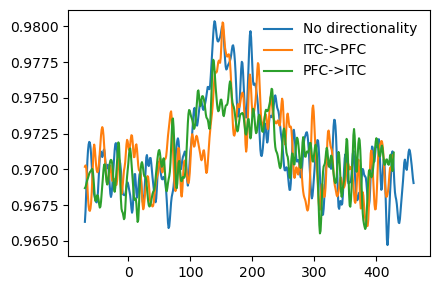

In [6]:
smooth_win = 2
fig_sz = np.array((3,2)) * 1.5

plt.figure(figsize=fig_sz)
plt.plot(time_stamps, smooth(corrs[25], smooth_win), label='No directionality')
plt.plot(time_stamps, smooth(corrs[0], smooth_win), label='ITC->PFC')
plt.plot(time_stamps, smooth(corrs[49], smooth_win), label='PFC->ITC')

plt.legend(frameon=False)
plt.tight_layout()

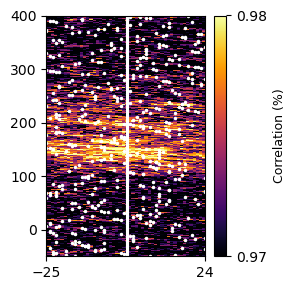

In [20]:
fig_sz = np.array((3,3)) * 1
colormap = 'inferno'
plot_xlim = [min(time_lags), max(time_lags)]
plot_ylim = [-50,400]
plot_clim = [.97,.98]

lag_max = np.nanargmax(corrs, axis=0)
t_max = time_lags[lag_max]

plt.figure(figsize=fig_sz)
fig = plt.pcolor(time_lags, time_stamps, corrs.T, 
                 cmap=colormap, clim=plot_clim)
clb = plt.colorbar(mappable=fig, ticks=plot_clim)
clb.set_label('Correlation (%)', fontsize=fig_sz[0]*3)

plt.axvline(0, color='w', lw=fig_sz[1]*.75)
plt.plot(t_max, time_stamps, marker='.', color='w', ls='None', markersize=fig_sz[0]*1)

plt.xlim(plot_xlim)
plt.xticks(plot_xlim)

plt.yticks([0,100,200,300,400])
plt.ylim(plot_ylim)

plt.tight_layout()

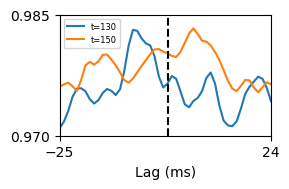

In [55]:
smooth_win = 1
fig_sz = np.array((3,2)) * 1

plot_xlim = [min(time_lags), max(time_lags)]
plot_ylim = [.97,.985]

t1 = 200
t2 = 220
plt.figure(figsize=fig_sz)
plt.plot(time_lags, smooth(corrs[:,t1], smooth_win), label=f't={int(time_stamps[t1])}')
plt.plot(time_lags, smooth(corrs[:,t2], smooth_win), label=f't={int(time_stamps[t2])}')

plt.xlabel('Lag (ms)')
plt.xlim(plot_xlim)
plt.xticks(plot_xlim)

plt.yticks(plot_ylim)
plt.ylim(plot_ylim)

plt.axvline(0, color='k', ls='--', lw=fig_sz[0]*.5)
plt.legend(fontsize=fig_sz[0]*2)
plt.tight_layout()

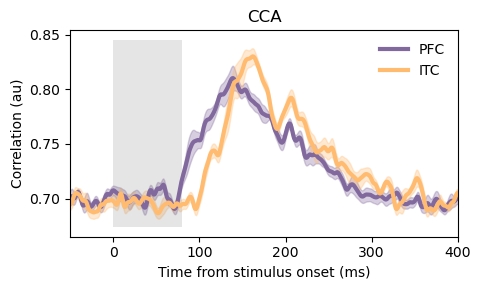

In [136]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [0,.06]
figure_size = np.array((5,3)) * 1

lead_0 = np.where(time_lags==0)[0][0]
lead_itc = 0
lead_pfc = -1

m_plot([corrs[:,lead_pfc,:], corrs[:,lead_itc,:]], [color_pfc,color_itc], error_method='sem', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'CCA', timepoints=time_stamps, figure_size=figure_size)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])
# plt.axhline(0)

plt.ylabel('Correlation (au)')
# plt.ylim(plot_ylim)
# plt.yticks([plot_ylim[0], plot_ylim[1]])
plt.tight_layout()

# plt.savefig(f'{FigDir}reg_beta_{myCond}.svg')

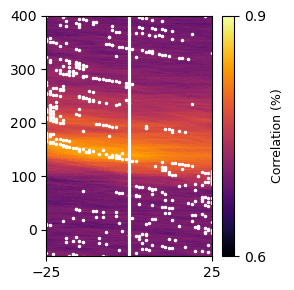

In [133]:
fig_sz = np.array((3,3)) * 1
colormap = 'inferno'
plot_xlim = [min(time_lags), max(time_lags)]
plot_ylim = [-50,400]
plot_clim = [.6,.9]

ave_corrs = np.nanmean(corrs, axis=0)

lag_max = np.nanargmax(ave_corrs, axis=0)
t_max = time_lags[lag_max]

plt.figure(figsize=fig_sz)
fig = plt.pcolor(time_lags, time_stamps, ave_corrs.T, 
                 cmap=colormap, clim=plot_clim)
clb = plt.colorbar(mappable=fig, ticks=plot_clim)
clb.set_label('Correlation (%)', fontsize=fig_sz[0]*3)

plt.axvline(0, color='w', ls='-', lw=fig_sz[1]*.75)
plt.plot(t_max, time_stamps, marker='.', color='w', ls='None', markersize=fig_sz[0]*1)

plt.xlim(plot_xlim)
plt.xticks(plot_xlim)

plt.yticks([0,100,200,300,400])
plt.ylim(plot_ylim)

plt.tight_layout()

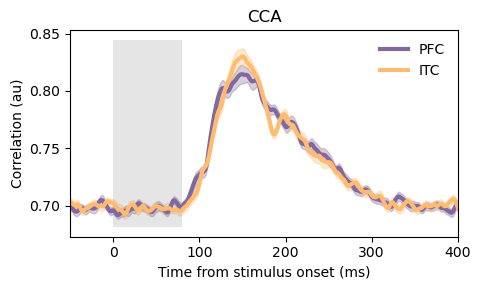

In [16]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [0,.06]
figure_size = np.array((5,3)) * 1

lag_idx = 0

m_plot([pfc2itc[:,lag_idx,:], itc2pfc[:,lag_idx,:]], [color_pfc,color_itc], error_method='sem', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'CCA', timepoints=time_stamps, figure_size=figure_size)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Correlation (au)')
# plt.ylim(plot_ylim)
# plt.yticks([plot_ylim[0], plot_ylim[1]])
plt.tight_layout()

# plt.savefig(f'{FigDir}reg_beta_{myCond}.svg')

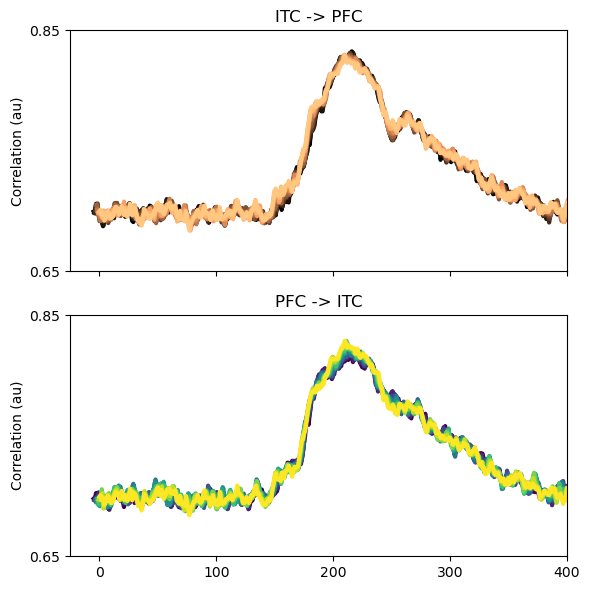

In [117]:
fig_sz = np.array((2,2)) * 3
n_lines = lag_dur + 1
plot_xlim = [-25,400]
plot_ylim = [.65,.85]
plot_lw = fig_sz[0]*.5

fig, (ax1,ax2) = plt.subplots(figsize=fig_sz, ncols=1, nrows=2, sharey=True, sharex=True)
colors1 = plt.cm.copper(np.linspace(0,1,n_lines))
colors2 = plt.cm.viridis(np.linspace(0,1,n_lines))

for ilag in range(lag_dur+1):
    ax1.plot(t_plot[ilag], np.nanmean(itc2pfc[:,ilag,:], axis=0), color=colors1[ilag], lw=plot_lw)
    ax2.plot(t_plot[ilag], np.nanmean(pfc2itc[:,ilag,:], axis=0), color=colors2[ilag], lw=plot_lw)

ax1.set_title('ITC -> PFC')
ax1.set_ylabel('Correlation (au)')

ax2.set_title('PFC -> ITC')
ax2.set_ylabel('Correlation (au)')

plt.xticks([0,100,200,300,400])
plt.xlim(plot_xlim)
plt.yticks(plot_ylim)
plt.ylim(plot_ylim)
plt.tight_layout()


In [119]:
if 0:
    fig_sz = np.array((2,2)) * 1.5
    n_lines = lag_dur + 1
    plot_xlim = [-50,400]
    plot_ylim = [.65,.85]

    fig, (ax1,ax2) = plt.subplots(figsize=fig_sz, ncols=1, nrows=2, sharey=True, sharex=True)

    # itc2pfc
    colors1 = plt.cm.copper(np.linspace(0,1,n_lines))
    ax1.set_prop_cycle('color', colors1)
    ax1.plot(time_stamps, np.nanmean(itc2pfc, axis=0).T)
    ax1.set_title('ITC -> PFC')
    ax1.set_ylabel('Correlation (au)')

    # pfc2itc
    colors2 = plt.cm.viridis(np.linspace(0,1,n_lines))
    ax2.set_prop_cycle('color', colors2)
    ax2.plot(time_stamps, np.nanmean(pfc2itc, axis=0).T)
    # ax2.set_title('PFC -> ITC')
    ax2.set_ylabel('firing rate (au)')

    plt.xticks([0,100,200,300,400])
    plt.xlim(plot_xlim)
    plt.yticks(plot_ylim)
    plt.ylim(plot_ylim)
    plt.tight_layout()

    # ax1.legend(list(np.arange(26)-25), ncols=3, frameon=False)
    # ax2.legend(list(np.arange(26)-25), ncols=3, frameon=False)


In [15]:
permute_reps = 100001
base_time_idx = (time_stamps>-50) & (time_stamps<50)

connectivity_base = np.nanmean(connectivity[:,base_time_idx], axis=1)

def test_stat(x, y, axis):
    return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)

p_val = np.zeros(connectivity.shape[1]) * np.nan
for itime in tqdm(range(connectivity.shape[1])):
    tmp_sample = connectivity[:,itime]
    p_val[itime] = permutation_test(data=(tmp_sample, connectivity_base), statistic=test_stat, alternative='greater',
                                    vectorized=True, axis=0, random_state=15, n_resamples=permute_reps).pvalue
    

  0%|          | 0/531 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


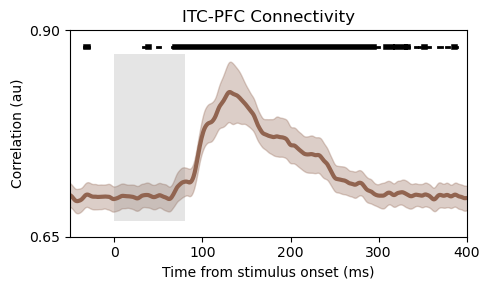

In [23]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [.65,.90]
fig_sz = np.array((5,3)) * 1
sig_line_loc = .88
sig_thresh_1 = .05
sig_thresh_2 = .001

m_plot([connectivity], [color_class1], error_method='std', 
       smooth_win=smooth_win, plot_title=f'ITC-PFC Connectivity', timepoints=time_stamps, figure_size=fig_sz)

sig_time = (p_val<sig_thresh_1).astype('float') * sig_line_loc
sig_time[sig_time==0] = np.nan
plt.plot(time_stamps, sig_time, color='k', lw=fig_sz[0]*.4)

sig_time = (p_val<sig_thresh_2).astype('float') * sig_line_loc
sig_time[sig_time==0] = np.nan
plt.plot(time_stamps, sig_time, color='k', lw=fig_sz[0]*.8)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Correlation (au)')
plt.ylim(plot_ylim)
plt.yticks(plot_ylim)

plt.tight_layout()

# plt.savefig(f'{FigDir}cca.svg')